In [1]:
from neurovlm.data import fetch_data, load_latent
from neurovlm import NeuroVLM

# Fetch models and datasets
fetch_data()

Data fetch complete. Cache directory: /home/rph/.cache/huggingface/hub


'/home/rph/.cache/huggingface/hub'

# Quickstart

This tutorial introduces the high-level, inference-only API. It walks through text-to-brain and brain-to-text generation and retrieval.

## Text-to-Brain: Generative

In [2]:
nvlm = NeuroVLM()
result = nvlm.text(["vision", "default mode network"]).to_brain(head="mse")
result.to_nifti() # returns list of nib.Nifti1Image

There are adapters available but none are activated for the forward pass.


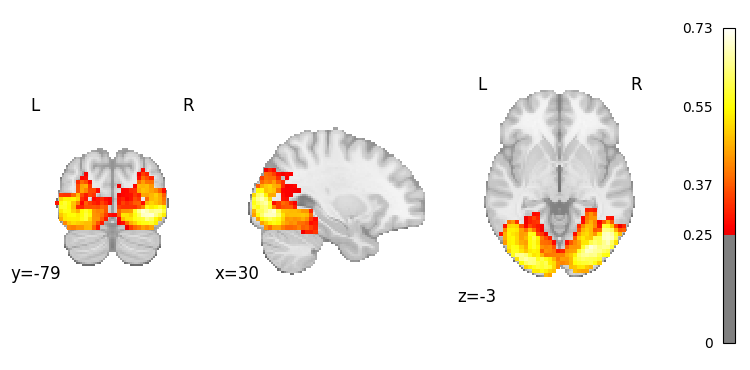

In [3]:
result.plot(0, threshold=0.25); # plot image for vision

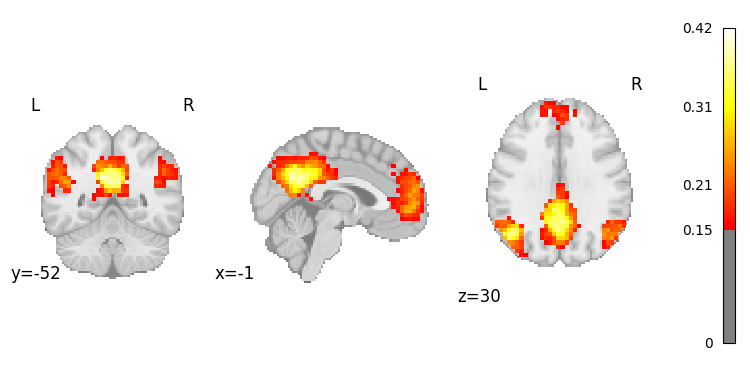

In [4]:
result.plot(1, threshold=0.15); # plot image for DMN

## Text-to-Brain: Contrastive Ranking & Retrieval

Contrastive models are used for ranking and retrieval. We can lookup similar neuroimages in a dataset, given a text query.

In [5]:
nvlm = NeuroVLM()
result = nvlm.text("motor").to_brain(head='infonce')
top = result.top_k(2) # each row pairs to a neuorimage that is most similar to the text query
top

There are adapters available but none are activated for the forward pass.


,dataset,dataset_index,title,description,cosine_similarity
0,networks,82,Shirer,Sensorimotor,0.438795
1,networks,130,WashU,Effector-hand,0.432333
2,neurovault,1939,Brain responses to anticipatory cues and milks...,There is substantial variability in percent to...,0.463300
3,neurovault,1068,Large-Scale Network Coupling with the Fusiform...,"Large-scale functional networks, as identified...",0.449919
4,pubmed,6401,Group-level variations in motor representation...,Navigated transcranial magnetic stimulation (T...,0.466430
5,pubmed,904,Ipsilateral motor cortex activation on functio...,"Distal, unilateral hand movements can be assoc...",0.459416


Each row in the `top` dataframe above, is paried to an image that can be viewed.

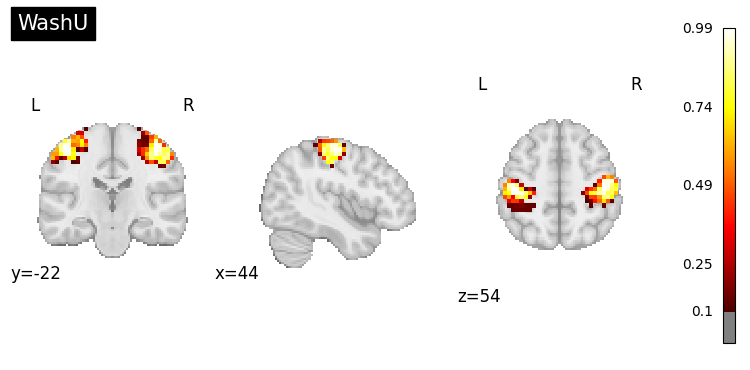

In [6]:
# WashU network atlas
top.plot_row(1, threshold=0.1);

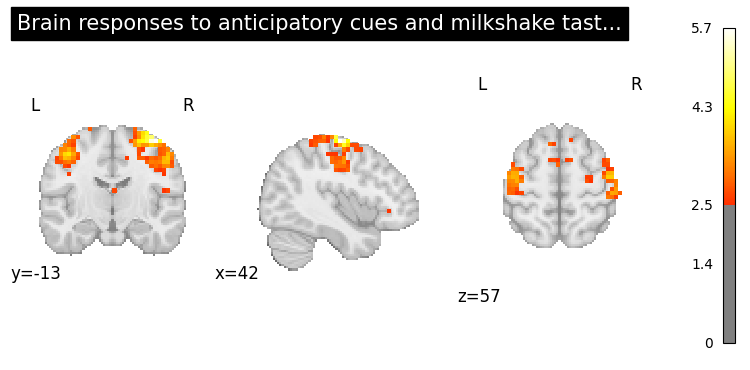

In [7]:
# NeuroVault
top.plot_row(2, threshold=2.5);

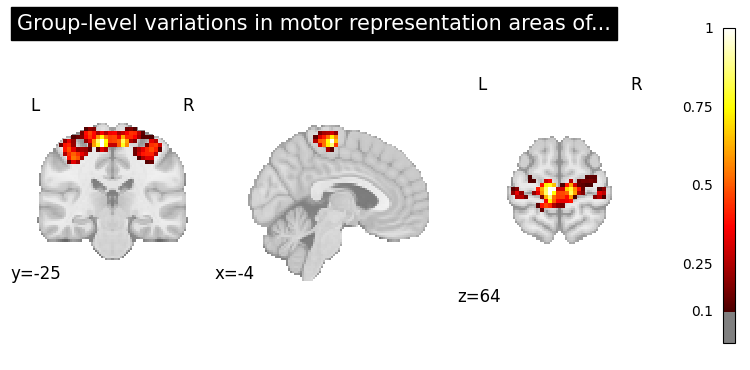

In [8]:
# PubMed
top.plot_row(4, threshold=0.1);

## Brain-to-Text: Contrastive Ranking & Retrieval

Here we use an auditory map as input from the Du atlas. We use the contrastive model to rank the most similar text across the datasets.

In [9]:
# Load networks examples images
networks = load_latent("networks_neuro")

# Transform rank text based on auditory network
nvlm = NeuroVLM()
result = nvlm.brain(networks["Du"]["AUD"]).to_text()
result.top_k(5).query("cosine_similarity > 0.4") # return up to 5 examples per dataset

,dataset,title,description,cosine_similarity
0,cogatlas,auditory stream segregation,The perceptual grouping of sounds to form cohe...,0.437669
1,cogatlas,auditory encoding,The process of storing auditory information in...,0.431347
2,cogatlas,music cognition,The processing of mental functions on auditory...,0.431245
3,cogatlas,acoustic phonetic processing,The cognitive ability to discriminate items on...,0.423635
4,cogatlas,auditory tone detection,Determining the presence of an auditory stimul...,0.417665
5,networks,Auditory,Auditory network (AUD; auditory cortex network...,0.470543
10,pubmed,The processing of temporal pitch and melody in...,An fMRI experiment was performed to identify t...,0.526884
11,pubmed,"Heschl's gyrus, posterior superior temporal gy...",A part of the auditory system automatically de...,0.504547
12,pubmed,Hierarchical processing of sound location and ...,Horizontal sound localization relies on the ex...,0.499913
13,pubmed,Brain bases for auditory stimulus-driven figur...,"Auditory figure-ground segregation, listeners'...",0.490401


## Brain-to-Text: Generative

Below, we use the auditory map again. The contrastive model ranks the most similar text across the n-gram dataset. The top-k terms are then passed to an LLM for generation. Terms are a good target since they are short and faster for LLM to process. We could also have the LLM generation over related publications, but generation will be slower.

The LLM used below is very small and will produce poor results in many cases. To improve generation:

- Customize the concept dataset to your priors.
- Customize the system instructions for your domain/task.
- Use a larger model, >= 7B parameters.

In [10]:
from neurovlm.retrieval_resources import _load_ngram, _load_latent_ngram
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load ngrams data
latent_ngram = _load_latent_ngram()
ngrams = _load_ngram() # to-do integrate ngram dataset into NeuroVLM class

# Top few terms based on cosine similarity, these will be passed to an LLM
cosine_similarity = result.query_embeddings[0] @ latent_ngram.T
indices_sorted = cosine_similarity.argsort(descending=True)
labels = ngrams[indices_sorted[:4]].tolist()
labels

['music', 'audio', 'sound', 'auditory regions']

In [12]:
# Generation
model_id = "HuggingFaceTB/SmolLM2-360M-Instruct"
device = "mps" if torch.backends.mps.is_available() else "cpu"
dtype  = torch.float16 if device == "mps" else torch.float32

tok = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=dtype).to(device).eval()

if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token

messages = [
    {"role": "system", "content": "Write a short paragraph explaing the following terms in the context of neuroimaging."},
    {"role": "user",   "content": "\n".join(labels)},
]

prompt = tok.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
inputs = tok(prompt, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    out = model.generate(
        **inputs,
        max_new_tokens=128,
        do_sample=False,   # deterministic
        num_beams=1,       # deterministic
        temperature=None,  # ignored when do_sample=False
        top_p=None,
        pad_token_id=tok.eos_token_id,
        eos_token_id=tok.eos_token_id,
    )

new_tokens = out[0, inputs["input_ids"].shape[-1]:]
print(tok.decode(new_tokens, skip_special_tokens=True))

The auditory regions refer to the specific areas of the brain that process sound and are responsible for interpreting and understanding musical information. These regions are located in the temporal lobe, specifically in the auditory cortex, and are involved in the perception of sound, pitch, melody, and rhythm. The auditory regions are also closely linked to the auditory centers in the brain, which are responsible for processing auditory information and controlling the movement of the auditory system.
